# Тестирование фреймворка обучения

Пример работы (и мб туториал для команды)

In [1]:
import sys

from src.models.mobilenet import MobileNetV2

sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import pandas as pd
from pathlib import Path

from src.models.lenet import LeNet
from src.trainer import Trainer
from src.dataset import HumanPosesDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import torch

In [2]:
import plotly.io as pio
pio.renderers.default = "browser" #кароче это нужно потому что в датаспелл кривая отрисовка 

### Датасет и лоадеры

In [3]:
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [4]:
batch_size = 64

In [5]:
CSV_PATH = Path("../data/human_poses_data/train_answers.csv")
TRAIN_DIR = Path("../data/human_poses_data/img_train")

df = pd.read_csv(CSV_PATH)
train_ids, val_ids = train_test_split(
    df['img_id'].values,
    test_size=0.2,
    stratify=df['target_feature'],
    random_state=42
)

train_df = df[df['img_id'].isin(train_ids)]
val_df = df[df['img_id'].isin(val_ids)]

train_dataset = HumanPosesDataset(
    root_dir=TRAIN_DIR.parent, mode='train', transform=train_transform
)
val_dataset = HumanPosesDataset(
    root_dir=TRAIN_DIR.parent, mode='train', transform=val_transform
)

train_idx = train_df.index.tolist()
val_idx = val_df.index.tolist()

max_train_samples = 256
max_val_samples = 128

train_dataset = Subset(train_dataset, train_idx[:max_train_samples])
val_dataset = Subset(val_dataset, val_idx[:max_val_samples])


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 256
Validation dataset size: 128


### Модель

In [6]:
model = LeNet(num_classes=18)
print(f"Model: LeNet")
print(f"Model architecture:\n{model}")

Model: LeNet
Model architecture:
LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=18, bias=True)
  )
)


In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [10]:
# Создаем тренер
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device = device,
    criterion=criterion,
    experiment_name="lenet_test",
    use_wandb=True,
    seed=42
)

history = trainer.train()

### Метрики


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.15      1.00      0.26        19
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         8

    accuracy                           0.15       128
  

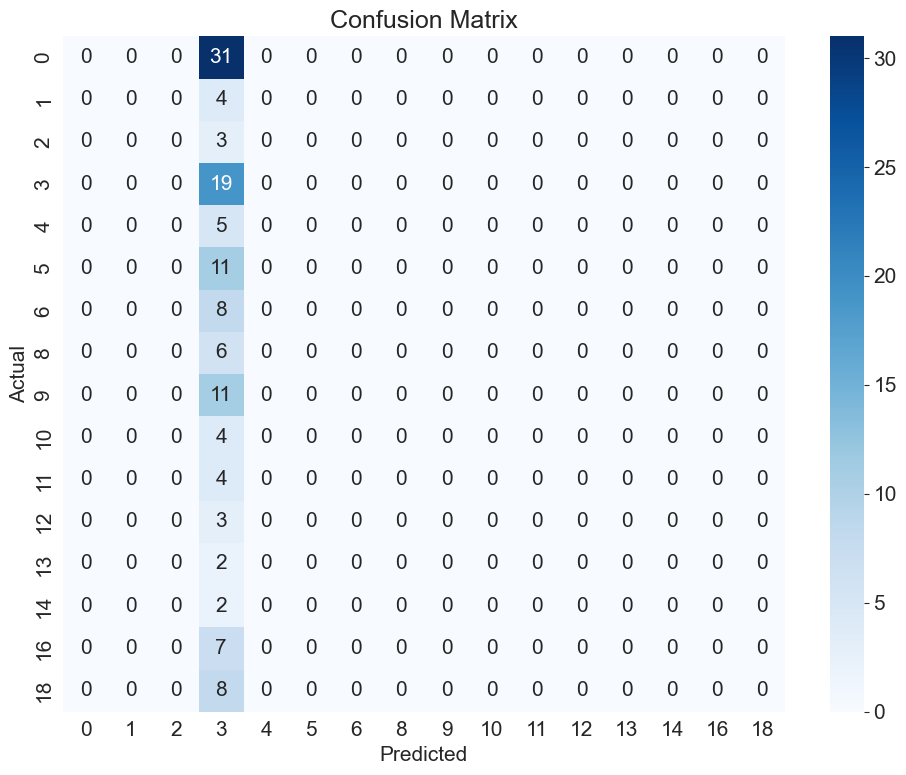


Macro F1-score: 0.0162
Macro Precision: 0.0093
Macro Recall: 0.0625


In [11]:
from src.utils import evaluate_model

label_names = sorted(val_df['target_feature'].unique())

metrics = evaluate_model(model, val_loader, device, label_names=label_names)

### Загрузка весов модели (обучение автоматически сохраняет последнюю и лучшую, лучшие иногда перекидываются в /best_models/

In [12]:
from src.utils import load_best_model

model = load_best_model(model, "checkpoints/lenet_test_best.pth", device=device)

✅ Loaded model weights from checkpoints/lenet_test_best.pth



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.15      1.00      0.26        19
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         8

    accuracy                           0.15       128
  

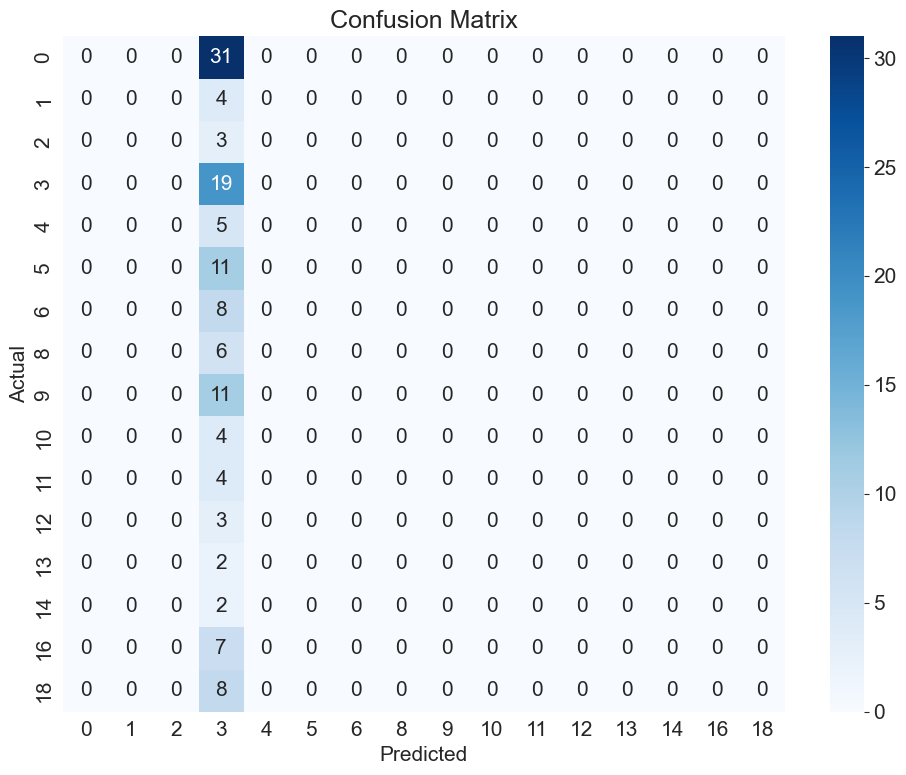


Macro F1-score: 0.0162
Macro Precision: 0.0093
Macro Recall: 0.0625


In [13]:
from src.utils import evaluate_model

label_names = sorted(val_df['target_feature'].unique())

metrics = evaluate_model(model, val_loader, device, label_names=label_names)

### Продолжение обучения 

In [14]:
from src.utils import load_training_state

model, optimizer, scheduler, start_epoch, history, best_f1 = load_training_state(
    model, optimizer, scheduler,
    checkpoint_path="checkpoints/lenet_test_last.pth",
    device=device
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,  # сколько ДОБАВИТЬ эпох
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    experiment_name="experiment",
    use_wandb=True
)
trainer.history = history
trainer.best_f1 = best_f1

history = trainer.train(start_epoch=start_epoch)

{'train_loss': [2.767088770866394,
  2.649383008480072,
  2.4832380414009094,
  2.4617056846618652,
  2.4153707027435303,
  2.416433870792389,
  2.412477731704712,
  2.3991516828536987,
  2.399082124233246,
  2.394005298614502],
 'val_loss': [2.649646759033203,
  2.5031222105026245,
  2.4770888090133667,
  2.4625264406204224,
  2.4201674461364746,
  2.4282995462417603,
  2.4259603023529053,
  2.4273794889450073,
  2.425844669342041,
  2.423372983932495],
 'train_f1': [0.014234875444839857,
  0.015784982935153583,
  0.037403205301074854,
  0.025311526479750778,
  0.025311526479750778,
  0.025311526479750778,
  0.025311526479750778,
  0.025311526479750778,
  0.025311526479750778,
  0.025311526479750778],
 'val_f1': [0.016156462585034014,
  0.016156462585034014,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994,
  0.02437106918238994]}

### Сабмиты

In [8]:
from torch.utils.data import DataLoader
from src.dataset import HumanPosesDataset

TEST_DIR = Path("../data/human_poses_data/img_test")
ROOT_DIR = TEST_DIR.parent

test_dataset = HumanPosesDataset(
    root_dir=ROOT_DIR,
    mode='test',
    transform=val_transform  
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,           
    shuffle=False,           
    num_workers=2,
    pin_memory=True
)


In [9]:
from src.utils import load_best_model

model = load_best_model(model, "checkpoints/lenet_test_best.pth", device=device)

✅ Loaded model weights from checkpoints/lenet_test_best.pth


In [13]:
from src.utils import make_submission

make_submission(
    model=model,
    test_loader=test_loader,
    device=device,
    output_path="../submissions/submission.csv"
)


Predicting: 100%|██████████| 83/83 [00:41<00:00,  1.99it/s]

✅ Submission saved to: ../submissions/submission.csv
